In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler #for standardization
from sklearn.ensemble import RandomForestClassifier #for feature importance
import seaborn as sns

In [2]:
df = pd.read_csv("MASTER_DATASET.csv")

In [3]:
df.drop(columns=['pcode'], inplace=True) # dropping the unneeded postal code column
df.head()

,oblast_or_country,# total population,# female population,# male population,# female younger population (0 - 14 years),# male younger population (0 - 14 years),# total younger population (0 - 14 years),# female older population (60 years and up),# male older population (60 years and up),# total older population (60 years and up),...,# battles,# explosions/remote violence,# violence against civilians,# fatalities,# civilian fatalities,# civilian injuries,# total infrastructure damage,# total access events,# unemployed people,period
0,Cherkaska,1157115,624475,532640,75552,81536,157088,196700,110769,307469,...,0,0,0,0,0,0,0,0,16808,Jan2022
1,Chernihivska,950773,518447,432326,61356,64084,125440,174896,90800,265696,...,0,0,0,0,0,0,0,0,10534,Jan2022
2,Chernivetska,887392,468777,418615,73482,78391,151873,116988,69688,186676,...,0,0,0,0,0,0,0,0,5969,Jan2022
3,Dnipropetrovska,3093176,1680750,1412426,226943,240091,467034,503014,265558,768572,...,0,0,0,0,0,0,0,0,23984,Jan2022
4,Donetska,4046487,2207252,1839235,204708,218811,423519,810872,465603,1276475,...,101,180,0,4,0,0,0,0,10008,Jan2022


**Standardizing the Data**

In [5]:
# Scaling the time column

reference_date = pd.to_datetime(df['period']).min()
df['scaled_time'] = (pd.to_datetime(df['period']) - reference_date).dt.days
df.drop(columns=['period'], inplace=True)
print(df['scaled_time'])

0        0
1        0
2        0
3        0
4        0
      ... 
520    608
521    608
522    608
523    608
524    608
Name: scaled_time, Length: 525, dtype: int64


In [6]:
# Encoding oblast column

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['oblast_or_country'] = le.fit_transform(df['oblast_or_country'])

In [7]:
df['scaled_time'] = pd.to_datetime(df['scaled_time'], unit='D', origin=0)
df.sort_values(by='scaled_time', inplace=True)
df.set_index('scaled_time', inplace=True)  # Setting scaled_time as the index

In [8]:
# Standard Scaler for standardization

numerical_features = df.columns.difference(['oblast_or_country']) #all except oblast (not standardizing)

scaler = StandardScaler()

# Standardizing the numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [9]:
scaled_idps_column = df['# registered IDPs']

min_scaled_idps = scaled_idps_column.min()
max_scaled_idps = scaled_idps_column.max()

print(f"Range of Scaled IDPs: {min_scaled_idps} to {max_scaled_idps}")

Range of Scaled IDPs: -0.9715046208234186 to 3.126069058173752


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

time_series_data = df[['oblast_or_country', '# registered IDPs']]

# TSplitting dataset
train_size = int(len(time_series_data) * 0.8)
train, test = time_series_data.iloc[:train_size, :], time_series_data.iloc[train_size:, :]

# ARIMA model training
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

# Making predictions
predictions = model_fit.forecast(steps=len(test.columns), index=test.index)

# Evaluating the model using RMSE
rmse = sqrt(mean_squared_error(test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plotting predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Train')
plt.plot(test.index, test.values, label='Test')
plt.plot(predictions.index, predictions.values, label='Predictions')
plt.legend()
plt.title('ARIMA Model Predictions')
plt.xlabel('Time')
plt.ylabel('# registered IDPs')
plt.show()

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ValueError: SARIMAX models require univariate `endog`. Got shape (420, 2).

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52427D-01    |proj g|=  6.20870D-01

At iterate    5    f=  3.32046D-01    |proj g|=  1.07016D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   6.000D-06   3.320D-01
  F =  0.33204586790848711     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Root Mean Squared Error (RMSE): 0.036515823052461434


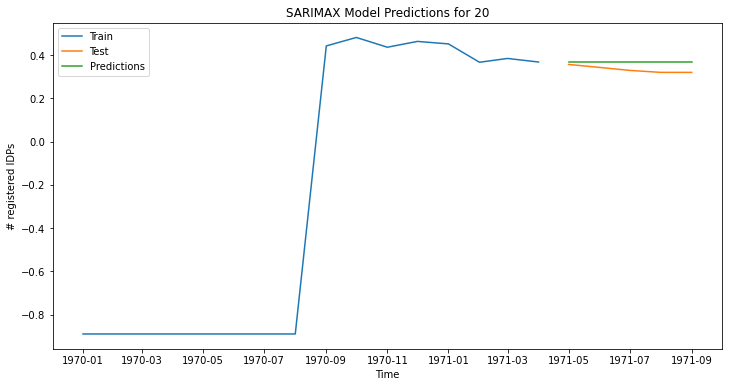

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Predicting '# registered IDPs'
selected_oblast = 20

# Extracting relevant columns (scaled_time is already set as the index!)
time_series_data = df[df['oblast_or_country'] == selected_oblast][['# registered IDPs']]

# Splitting dataset
train_size = int(len(time_series_data) * 0.8) #0.8 train, 0.2 test
train, test = time_series_data.iloc[:train_size, :], time_series_data.iloc[train_size:, :]

# SARIMAX model training
model = SARIMAX(train, order=(0, 1, 1), seasonal_order=(0, 0, 1, 12))  # Optimal from grid search
model_fit = model.fit()

# Making predictions
predictions = model_fit.get_forecast(steps=len(test))
predicted_values = predictions.predicted_mean

# Evaluating the model using RMSE
rmse = sqrt(mean_squared_error(test, predicted_values))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['# registered IDPs'], label='Train')
plt.plot(test.index, test['# registered IDPs'], label='Test')
plt.plot(test.index, predicted_values, label='Predictions')
plt.legend()
plt.title(f'SARIMAX Model Predictions for {selected_oblast}')
plt.xlabel('Time')
plt.ylabel('# registered IDPs')
plt.show()

HYPERPARAMETER TUNING

In [ ]:
#Using a grid search to find optimal values for "order" and "seasonal_order"

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

best_rmse = float('inf')
best_order = None
best_seasonal_order = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
            model_fit = model.fit()
            predictions = model_fit.get_forecast(steps=len(test)).predicted_mean
            rmse = sqrt(mean_squared_error(test, predictions))

            if rmse < best_rmse:
                best_rmse = rmse
                best_order = param
                best_seasonal_order = param_seasonal

        except:
            continue

print(f'Best RMSE score: {best_rmse}')
print(f'Best order: {best_order}')
print(f'Best seasonal order: {best_seasonal_order}')